# Evaluation Notebook

To load data it might be necessary to adapt the path of the loaded json files.

The json files contain an object for each run experiment in the list under "runResults"
The aviable fields are shown below but first a bit if io and data organization:

In [3]:
import json
imageExportPath = '/home/gocht/ma/thesis/sat-paper/images/'
with open('/home/gocht/ma/thesis/benchresults/incphp/sat-paper-run1.json', 'r') as jsonFile:
    config = json.loads(jsonFile.read())
with open('/home/gocht/ma/thesis/benchresults/incphp/sat-paper-run1-extension.json', 'r') as jsonFile:
    ext = json.loads(jsonFile.read())
config["runResults"].extend(ext["runResults"])

In [4]:
confIds = dict()
for experiment in config["runResults"]:
    conf = json.dumps(experiment["conf"]["setup"], indent=4)
    confId = hash(conf)
    confIds[confId] = conf

In [5]:
import math


def computeName(x):
    name = ''
    if (x['conf.setup.incremental']):
        name += 'incr. '
    else:
        name += 'non incr. '
    if x['conf.setup.variant.alternate']:
        name += 'exhaustive '
    if x['conf.setup.variant.3sat']:
        name += '3SAT '
    if x['conf.setup.variant.addAssumed']:
        name += 'force learn '
    if x['conf.setup.variant.extendedResolution']:
        name += 'ext. resolution '
    if x['conf.setup.record']:
        name += ''
    if x['conf.setup.variant.fixedUpperBound']:
        name+= 'nu'
    if name == 'incr. ' or name == 'non incr. ':
        name += 'naive'
    return name

In [6]:
from pandas.io.json import json_normalize
import pandas

for entry in config["runResults"]:
    try:
        print(entry['conf.setup.variant.fixedUpperBound'])
    except:
        pass

df = json_normalize(config["runResults"])
toFillNan = [
    "incphp.result.executionTime.userTime",
    "incphp.result.executionTime.systemTime",
    "incphp.result.executionTime.returnCode"
]

df[toFillNan] = df[toFillNan].fillna(value=0.0)
df['conf.setup.variant.fixedUpperBound'] = df['conf.setup.variant.fixedUpperBound'].fillna(False)
df = df.assign(
    time = lambda x: 
        #x["incphp.result.executionTime.userTime"]
        #+ x["incphp.result.executionTime.systemTime"],
        x['incphp.result.executionTime.wallClockTime'],
    error = lambda x: 
        (x["incphp.result.executionTime.returnCode"] != 0),
    confId = [hash(json.dumps(experiment["conf"]["setup"], indent=4)) for experiment in config["runResults"]]
)
df = df.assign(name = lambda x: x.apply(computeName, axis = 1))

The following is a list of all fields the data has and is generated from the json file. Note that 'incphp.result.solves'
contains a list containing a dict with information about each step of algorithm in the concrete experiment.

In [7]:
list(df)

['%limits.RLIMIT_AS',
 '%limits.RLIMIT_CPU',
 'conf.numPigeons',
 'conf.run',
 'conf.setup.incremental',
 'conf.setup.record',
 'conf.setup.solver',
 'conf.setup.variant.3sat',
 'conf.setup.variant.addAssumed',
 'conf.setup.variant.alternate',
 'conf.setup.variant.extendedResolution',
 'conf.setup.variant.fixedUpperBound',
 'incphp.parameters.3sat',
 'incphp.parameters.addAssumed',
 'incphp.parameters.alternate',
 'incphp.parameters.binDir',
 'incphp.parameters.dimspec',
 'incphp.parameters.extendedResolution',
 'incphp.parameters.fixedUpperBound',
 'incphp.parameters.incremental',
 'incphp.parameters.numPigeons',
 'incphp.parameters.print',
 'incphp.parameters.record',
 'incphp.parameters.solver',
 'incphp.result.executionTime.returnCode',
 'incphp.result.executionTime.systemTime',
 'incphp.result.executionTime.userTime',
 'incphp.result.executionTime.wallClockTime',
 'incphp.result.learnedClauseEval.numLearnedClauses',
 'incphp.result.learnedClauseEval.numLearnedClausesWithAssumedLit

# Plot of Algorithm runtime, per number of pigeons:

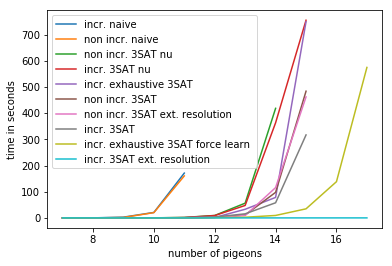

In [8]:
import matplotlib.pyplot as plt
import statistics

d = df[
      (df['error'] == False)
    & (df['conf.setup.record'] == False)
    & (
        (df['incphp.parameters.alternate'] == False)
      | (
         (df['conf.setup.incremental'] == True)
        )
      )
    & (df['conf.numPigeons'] > 6)
]

plots = list()
for confId, data in d.groupby("confId"):
    name = data.iloc[0]["name"]
    points = list()
    maxPigeon = 0
    maxTime = 0
    for numPigeons, data in data.groupby('conf.numPigeons'):
        if (len(data["time"].values) > 3):
            points.append((
                numPigeons,
                statistics.mean(data["time"].values)
            ))
            if (numPigeons > maxPigeon):
                maxPigeon = numPigeons
                maxTime = statistics.mean(data["time"].values)
    plots.append(((maxPigeon, -maxTime), name, points))

for _, name, points in sorted(plots):
    plt.plot(*zip(*points), label=name)

plt.xlabel("number of pigeons")
plt.ylabel("time in seconds")
#plt.semilogy()
plt.legend()
plt.savefig(imageExportPath + 'performance.svg', format='svg', bbox_inches='tight')
plt.show()

## Standard deviations, and a sorted list of runtimes for incremental non incremental 3 SAT

In [9]:
inc = sorted(df[
      (df['conf.setup.incremental'] == True)
    & (df['conf.setup.record'] == False)
    & (df['conf.setup.variant.3sat'] == True)
    & (df['conf.setup.variant.addAssumed'] == False)
    & (df['conf.setup.variant.alternate'] == False)
    & (df['conf.setup.variant.extendedResolution'] == False)
    & (df['conf.numPigeons'] == 15)
]["time"].values)

normal = sorted(df[
      (df['conf.setup.incremental'] == False)
    & (df['conf.setup.record'] == False)
    & (df['conf.setup.variant.3sat'] == True)
    & (df['conf.setup.variant.addAssumed'] == False)
    & (df['conf.setup.variant.alternate'] == False)
    & (df['conf.setup.variant.extendedResolution'] == False)
    & (df['conf.numPigeons'] == 15)
]["time"].values)

print(statistics.mean(inc), statistics.median(inc), statistics.stdev(inc))
print(statistics.stdev(normal))
list(zip(inc,normal))

571.995632422 544.360200097 307.07430101627915
210.30032483972028


[(115.51779889297904, 404.46108317701146),
 (159.36816601001192, 410.0536771400366),
 (182.55805559799774, 448.47474906698335),
 (219.85217274300521, 452.14308207004797),
 (234.74353765504202, 483.36593654699391),
 (305.6328133479692, 488.58059442800004),
 (352.84490748704411, 494.69735980697442),
 (416.79516551201232, 512.87191676098155),
 (444.03111084899865, 539.2300310760038),
 (513.34967770200456, 552.71724705904489),
 (575.37072249205085, 554.04712713701883),
 (818.98762299004011, 793.13515228906181),
 (848.28944638895337, 900.00897643400822),
 (866.32408099703025, 900.00907967798412),
 (885.93377530598082, 900.0107001940487),
 (900.00972535694018, 900.01084191998234),
 (900.01471877598669, 900.01128732797224),
 (900.02633592800703, 900.0194671190111),
 (900.03309557097964, 900.02341399306897),
 (900.22971883695573, 900.05753717396874)]

## Plots for individual solve steps.

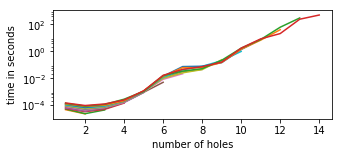

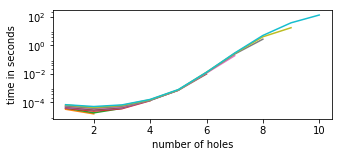

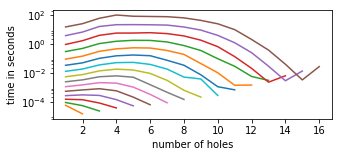

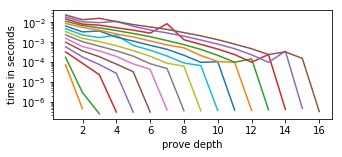

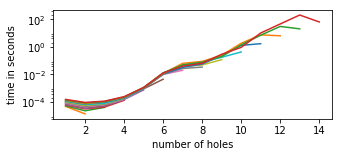

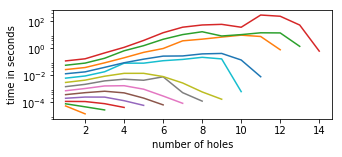

In [92]:
import matplotlib.pyplot as plt
import statistics

d = df[
      (df['error'] == False)
    & (df['conf.setup.record'] == False)
    & (df['conf.setup.incremental'] == True)
   #& (df['conf.numPigeons'] > 12)
   #& (df['conf.setup.variant.addAssumed'] == False)
]

for confId, data in d.groupby("confId"):
    plt.figure(figsize=(5,2))
    name = data.iloc[0]["name"]
    for numPigeons, data in data.groupby('conf.numPigeons'):
        pts = dict()
        for idx, dat in data.iterrows():
            for row in dat['incphp.result.solves']:
                lst =  pts.get(row['makespan'], list())
                lst.append(row['time'])
                pts[row['makespan']] = lst

        points = list()
        for ms, times in pts.items():
            if len(times) > 3:
                points.append((ms, statistics.mean(times)))
        if data.iloc[0]['conf.setup.variant.extendedResolution'] == True:
            plt.xlabel("prove depth")
        else:
            plt.xlabel("number of holes")
        plt.ylabel("time in seconds")
        plt.plot(*zip(*points), label=name)
        
    plt.semilogy()
    #plt.legend(bbox_to_anchor=(2,1))
    plt.savefig(imageExportPath + name.replace(' ','').replace('.','') + '.svg', format='svg', bbox_inches='tight')
    plt.show()

## Ratio of learnd clauses, that contain the assumed literal.

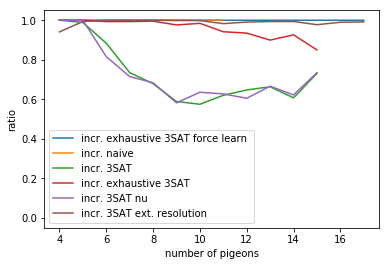

In [93]:
import matplotlib.pyplot as plt
import statistics

d = df[
      (df['error'] == False)
    & (df['conf.setup.record'] == True)
    & (df['conf.setup.incremental'] == True)
    & (df['conf.numPigeons'] > 3)
]

for confId, data in d.groupby("confId"):
    name = data.iloc[0]["name"]
    points = list()
    for numPigeons, data in data.groupby('conf.numPigeons'):
        score = list()
        for idx, dat in data.iterrows():
            for row in dat['incphp.result.solves']:
                if (row['makespan'] == numPigeons - 2):
                    score.append(
                        row['numLearnedClausesWithAssumedLiteral'] /
                        row['numLearnedClauses']
                    )
#        nlc = data['incphp.result.learnedClauseEval.numLearnedClauses'].values
#        nlcwal = data['incphp.result.learnedClauseEval.numLearnedClausesWithAssumedLiteral'].values
#        score = list(map(lambda x: x[0]/x[1], zip(nlcwal, nlc)))
        
        if (len(score) > 3):
            points.append((
                numPigeons,
                statistics.mean(score)
            ))
    ax = plt.gca()
    ax.set_ylim([-0.05,1.05])
    plt.xlabel("number of pigeons")
    plt.ylabel("ratio")
    plt.plot(*zip(*points), label=name)

#plt.semilogy()
plt.legend()
plt.savefig(imageExportPath + 'clausesWithAssumed.svg', format='svg', bbox_inches='tight')
plt.show()

### Same for individual steps.

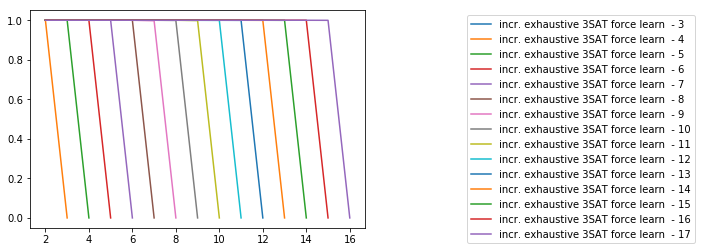

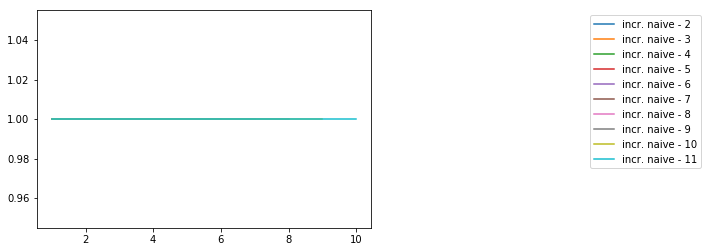

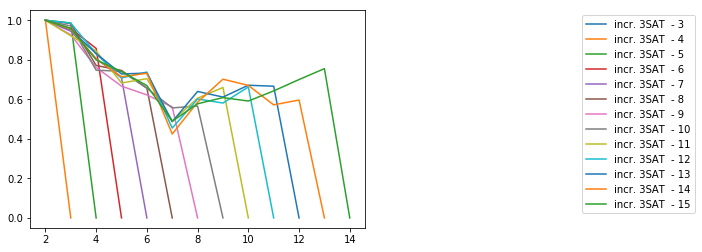

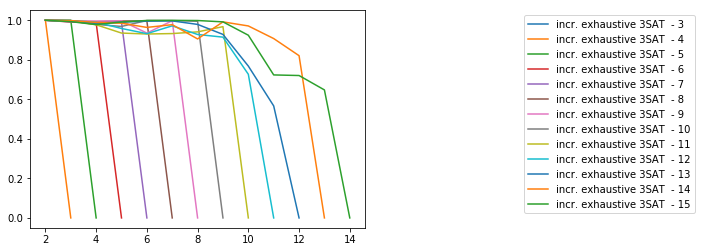

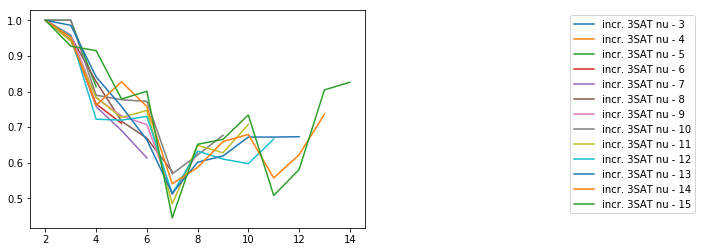

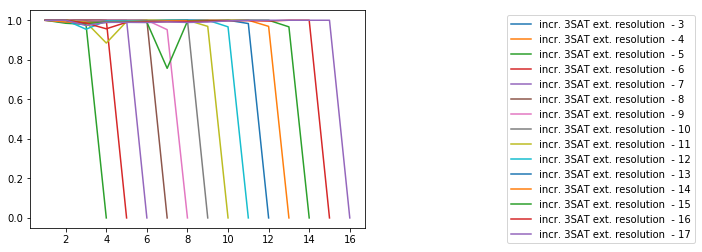

In [94]:
import matplotlib.pyplot as plt
import statistics

d = df[
      (df['error'] == False)
    & (df['conf.setup.record'] == True)
    & (df['conf.setup.incremental'] == True)
   #& (df['conf.setup.variant.3sat'] == False)
   #& (df['conf.numPigeons'] > 12)
   #& (df['conf.setup.variant.addAssumed'] == False)
]

for confId, data in d.groupby("confId"):
    for numPigeons, data in data.groupby('conf.numPigeons'):
        name = data.iloc[0]["name"]
        name += " - " + str(numPigeons)
        nlc = dict()
        nlcwal = dict()
        pts = dict()
        for idx, dat in data.iterrows():
            lpts = dict()
            for row in dat['incphp.result.solves']:
                nlc[row['makespan']] = row['numLearnedClauses']
                nlcwal[row['makespan']] = row['numLearnedClausesWithAssumedLiteral']

            for i in reversed(sorted(nlc.keys())):
                if (i != 1):
                    nlc[i] = nlc[i] - nlc[i - 1]
                    nlcwal[i] = nlcwal[i] - nlcwal[i - 1]

            for i in reversed(sorted(nlc.keys())):
                lst =  pts.get(i, list())
                if nlc[i] > 0:
                    lst.append(nlcwal[i] / nlc[i])
                    pts[i] = lst

        points = list()
        for i in reversed(sorted(pts.keys())):
            if len(pts[i]) > 3:
                points.append((i, statistics.mean(pts[i])))
        
        plt.plot(*zip(*points), label=name)

    #plt.semilogy()
    plt.legend(bbox_to_anchor=(2,1))
    plt.show()

## Ratio of assumtions that have been found as learned clause

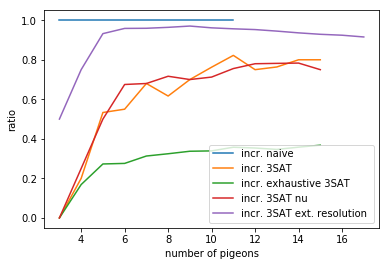

In [95]:
 'incphp.result.learnedClauseEval.numSolvesWithAssumption'
 'incphp.result.learnedClauseEval.numSolvesWithAssumptionFound'
 'incphp.result.learnedClauseEval.numSolvesWithSubsetAssumptionFound'

import matplotlib.pyplot as plt
import statistics

d = df[
      (df['error'] == False)
    & (df['conf.setup.record'] == True)
    & (df['conf.setup.incremental'] == True)
    & (df['incphp.parameters.addAssumed'] == False)
]

for confId, data in d.groupby("confId"):
    name = data.iloc[0]["name"]
    points = list()
    for numPigeons, data in data.groupby('conf.numPigeons'):
        score = list()
        for idx, dat in data.iterrows():
            for row in dat['incphp.result.solves']:
                if (row['makespan'] == numPigeons - 2):
                    score.append(
                        row['numSolvesWithSubsetAssumptionFound'] /
                        row['numSolvesWithAssumption']
                    )
#        nlc = data['incphp.result.learnedClauseEval.numLearnedClauses'].values
#        nlcwal = data['incphp.result.learnedClauseEval.numLearnedClausesWithAssumedLiteral'].values
#        score = list(map(lambda x: x[0]/x[1], zip(nlcwal, nlc)))
        
        if (len(score) > 3):
            points.append((
                numPigeons,
                statistics.mean(score)
            ))

    plt.plot(*zip(*points), label=name)
    
plt.xlabel("number of pigeons")
plt.ylabel("ratio")
#plt.semilogy()
plt.legend()
plt.savefig(imageExportPath + 'assumedLearned.svg', format='svg', bbox_inches='tight')
plt.show()

### Same for individual steps

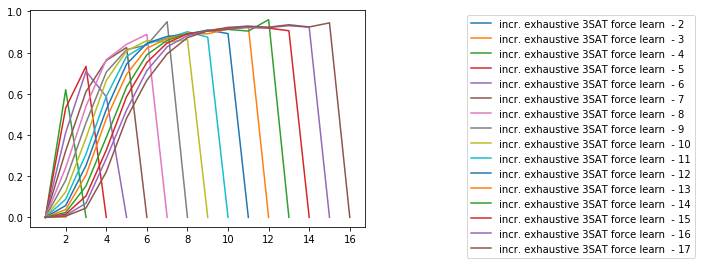

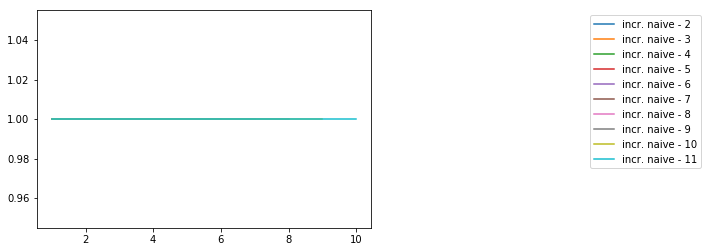

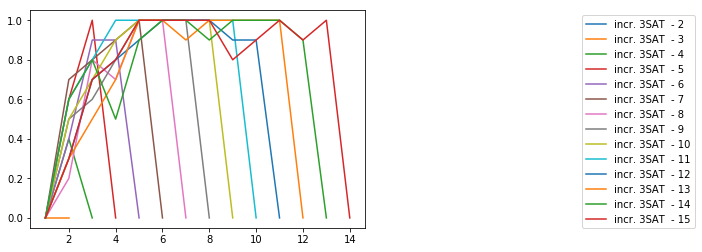

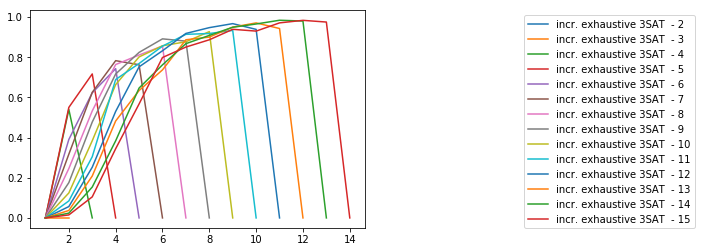

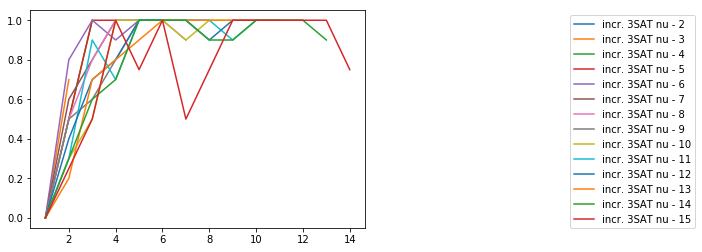

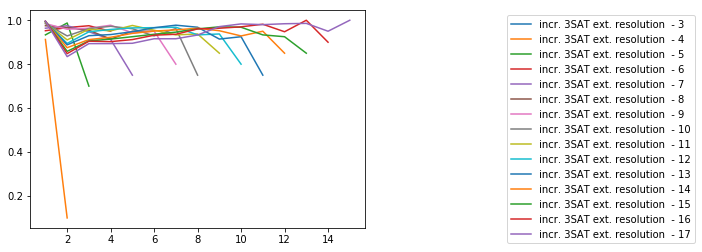

In [96]:
import matplotlib.pyplot as plt
import statistics

d = df[
      (df['error'] == False)
    & (df['conf.setup.record'] == True)
    & (df['conf.setup.incremental'] == True)
   #& (df['conf.setup.variant.3sat'] == False)
   #& (df['conf.numPigeons'] > 12)
   #& (df['conf.setup.variant.addAssumed'] == False)
]

for confId, data in d.groupby("confId"):
    for numPigeons, data in data.groupby('conf.numPigeons'):
        name = data.iloc[0]["name"]
        name += " - " + str(numPigeons)
        nlc = dict()
        nlcwal = dict()
        pts = dict()
        for idx, dat in data.iterrows():
            lpts = dict()
            for row in dat['incphp.result.solves']:
                nlc[row['makespan']] = row['numSolvesWithAssumption']
                nlcwal[row['makespan']] = row['numSolvesWithSubsetAssumptionFound']

            for i in reversed(sorted(nlc.keys())):
                if (i != 1):
                    nlc[i] = nlc[i] - nlc[i - 1]
                    nlcwal[i] = nlcwal[i] - nlcwal[i - 1]

            for i in reversed(sorted(nlc.keys())):
                lst =  pts.get(i, list())
                if nlc[i] > 0:
                    lst.append(nlcwal[i] / nlc[i])
                    pts[i] = lst

        points = list()
        for i in reversed(sorted(pts.keys())):
            if len(pts[i]) > 3:
                points.append((i, statistics.mean(pts[i])))
        
        plt.plot(*zip(*points), label=name)

    #plt.semilogy()
    plt.legend(bbox_to_anchor=(2,1))
    plt.show()